### The Dataset is stored in the ```dataset``` folder 
downloaded from ```http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip```
### The GloVe vector embeddings are in the ```glove``` folder 
downloaded from ```https://github.com/stanfordnlp/GloVe```
### The Counter-Fitted vectors are in the ```counter-fitted``` folder
download from ```https://github.com/nmrksic/counter-fitting/blob/master/word_vectors/counter-fitted-vectors.txt.zip```
(see referenced paper [20])


# Import dependecies 
Start by importing all the required libraries

In [1]:
"""
Python 3.8
Tensorflow 2.3.1
Keras 2.4.3

wordcloud 1.8.0
"""
import tensorflow as tf
from keras.preprocessing.text import Tokenizer

import matplotlib.pyplot as plt
from wordcloud import WordCloud

import numpy as np
import pandas as pd
import pickle
import os
import re
from keras.preprocessing.text import Tokenizer

# define constants
DATA_SET = "dataset/train.csv"
COUNTER_FITTED_vectors = "counter-fitted/counter-fitted-vectors.txt" 
GLOVE_EMBEDDINGS = "glove/glove.840B.300d.txt"


# Process dataset
### Read the dataset file and return a data frame


In [2]:
def process_dataset_Sentiment140(file_path: str ):
    # load the data file into a data frame
    df = pd.read_csv(file_path,encoding = 'latin',header=None)
    
    # Rename the columns so we can reference them later
    df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
    
    # drop all the columns we don't need
    df = df.drop(['id', 'date', 'query', 'user_id'], axis=1) 
    
    # change all 4's to 1's (just for neatness)
    df.loc[df['sentiment'] == 4, 'sentiment'] = 1
    
    # sort all the rows by the sentiment columns
    df.sort_values(by=['sentiment'])
    
    return df
    

### Read in the dataset file and show the first 5 rows of the data frame


In [3]:
data_frame = process_dataset_Sentiment140(DATA_SET)
data_frame.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


### Plot the data
#### We see that we have 2 types of sentiments, ```0 = negative``` and ```1 = positive```. We have 800,000 data points for each type of sentiment

Text(0.5, 1.0, 'Sentiment Distribution')

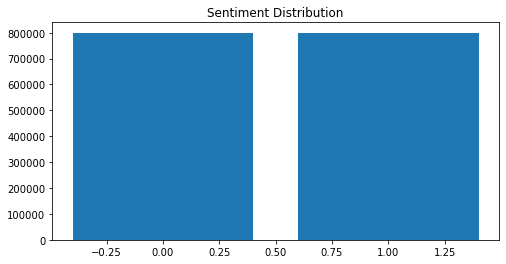

In [4]:
val_count = data_frame.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Distribution")

### We need to remove hyperlinks from the text - define a regex here to use

In [5]:
# regex to use to clean the text data, keep only the characters, numbers and apostrophe
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9']+"

### Use the regex to clean all our text entries and write back to the data frame

In [6]:
def clean_text(text, stem=False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    return text

In [7]:
data_frame.text = data_frame.text.apply(lambda x: clean_text(x))

In [8]:
data_frame.head()

,sentiment,text
0,0,awww that's a bummer you shoulda got david car...
1,0,is upset that he can't update his facebook by ...
2,0,i dived many times for the ball managed to sav...
3,0,my whole body feels itchy and like its on fire
4,0,no it's not behaving at all i'm mad why am i h...


# Wordcloud of ```positive``` sentiments

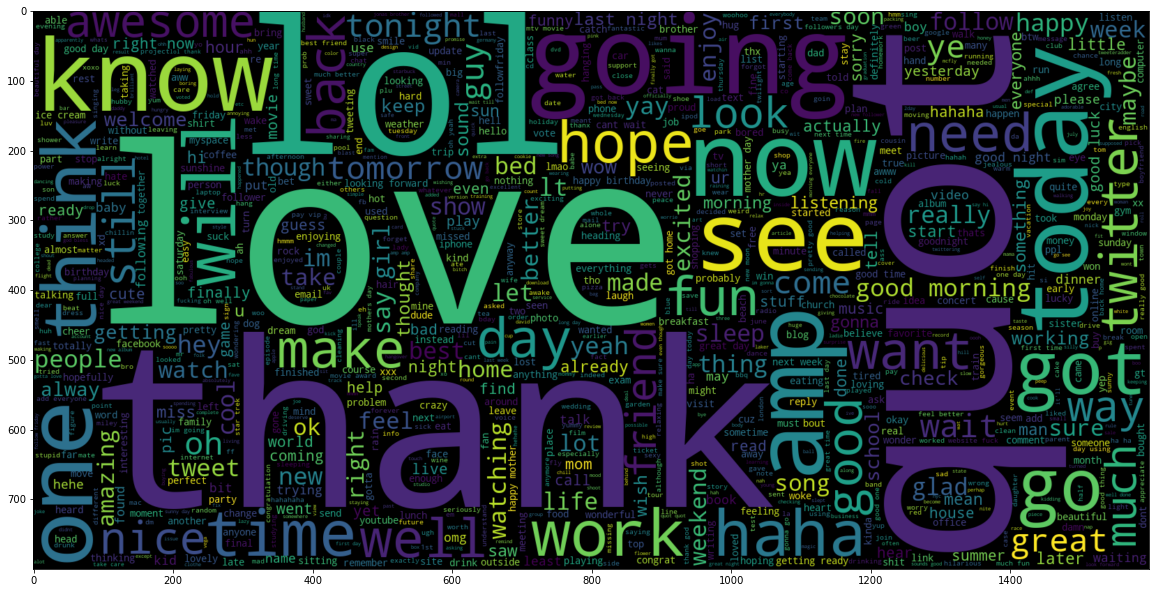

In [9]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800).generate(" ".join(data_frame[data_frame.sentiment == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

# Wordcloud of ```negative``` sentiments

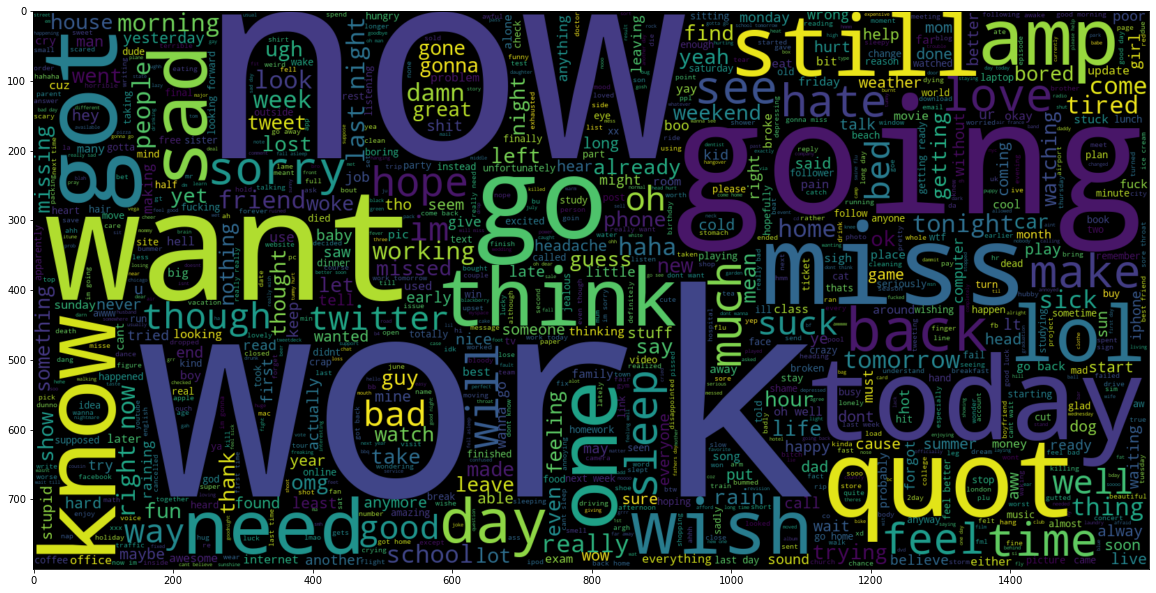

In [10]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800).generate(" ".join(data_frame[data_frame.sentiment == 0].text))
plt.imshow(wc , interpolation = 'bilinear')